In [1]:
#Importing necessary libraries
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
# Define image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  
        std=[0.229, 0.224, 0.225]
    ),
])

In [3]:
# Load pretrained ResNet50 model, remove classification head
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove last fc layer
model.eval()

/home/slakkaraju/flowers/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/slakkaraju/flowers/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [4]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [5]:
# Path to your images folder
image_folder = "/home/slakkaraju/flowers/flowers"

In [6]:
# Store embeddings and image paths
embeddings = []
image_paths = []

with torch.no_grad():
    for img_file in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_file)
        try:
            image = Image.open(img_path).convert('RGB')
            input_tensor = preprocess(image).unsqueeze(0).to(device)  # Add batch dim
            embedding = model(input_tensor)
            embedding = embedding.squeeze().cpu().numpy()  # Flatten to 1D vector
            embeddings.append(embedding)
            image_paths.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

embeddings = np.array(embeddings)

In [7]:
#Verifying values from 1st index
embeddings[0]

array([0.10267993, 0.29097244, 0.5115832 , ..., 0.21209209, 0.07435831,
       0.03825712], shape=(2048,), dtype=float32)

In [8]:
# Save embeddings and paths for later use (e.g., numpy file or pickle)
np.save('flower_image_embeddings.npy', embeddings)
with open('image_paths.txt', 'w') as f:
    for path in image_paths:
        f.write(f"{path}\n")

print(f"Extracted embeddings for {len(embeddings)} images.")

Extracted embeddings for 13862 images.


In [9]:
# Load embeddings saved earlier
embeddings = np.load('flower_image_embeddings.npy')

# Define number of clusters (adjust based on your data)
num_clusters = 10

In [10]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

In [11]:
# Save cluster labels for each image
np.save('cluster_labels.npy', cluster_labels)
print("Clustering completed.")

Clustering completed.


In [12]:
# Load embeddings and cluster labels
embeddings = np.load('flower_image_embeddings.npy')
cluster_labels = np.load('cluster_labels.npy')

In [13]:
#Use PCA to reduce dimensionality before t-SNE for faster processing
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

In [14]:
# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_pca)

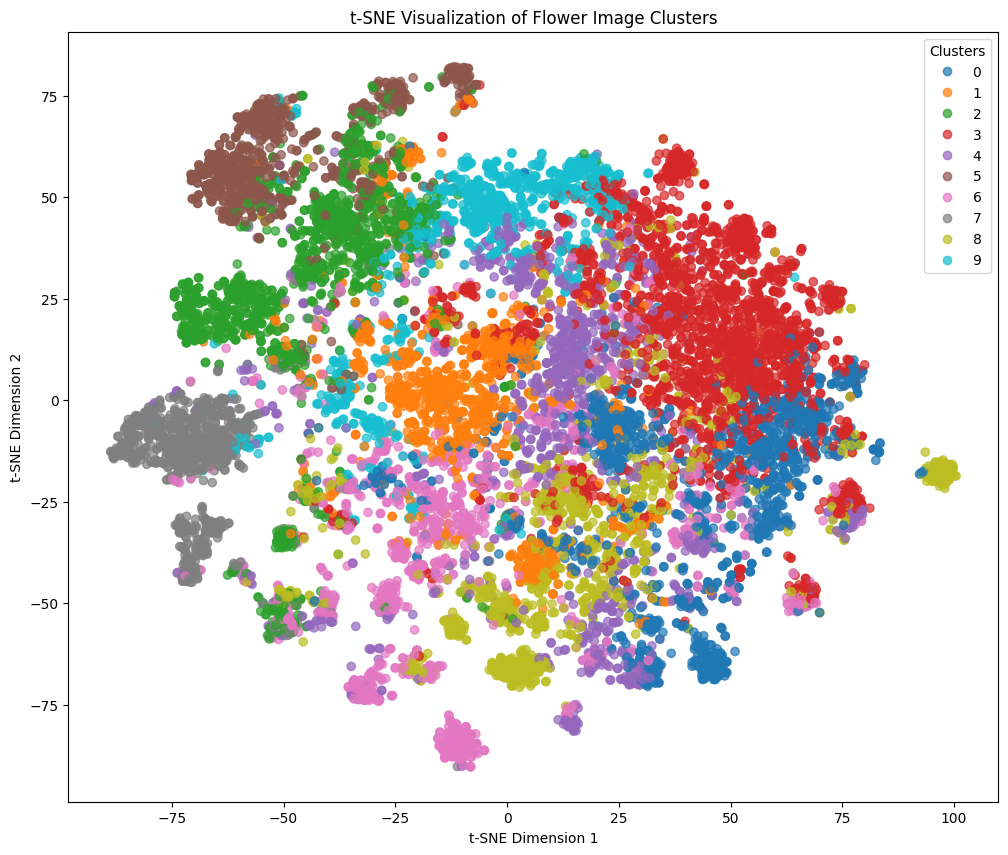

In [15]:
# Plot with clusters using different colors
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("t-SNE Visualization of Flower Image Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

Step 3: Load Embeddings and Metadata into Qdrant

In [16]:
# Connect to local Qdrant

from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import PointStruct

client = QdrantClient(host='localhost', port=6333)

In [17]:
# Create collection (recreate if exists) with updated vectors_config parameter
collection_name = 'flower_images'
vectors_config = models.VectorParams(
    size=embeddings.shape[1],  # dimension of embeddings, e.g., 2048
    distance=models.Distance.COSINE  # or Euclid, Dot
)
client.recreate_collection(
    collection_name=collection_name,
    vectors_config=vectors_config
)

/tmp/ipykernel_37524/1123364067.py:7: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [18]:
# Load image paths and cluster labels
with open('image_paths.txt', 'r') as f:
    image_paths = [line.strip() for line in f]

# Prepare Qdrant points with payload (filepath and cluster)
points = [
    PointStruct(
        id=i,
        vector=embeddings[i].tolist(),
        payload={"filepath": image_paths[i], "cluster": int(cluster_labels[i])}
    )
    for i in range(len(embeddings))
]

In [19]:
# Upload points in batches
batch_size = 500
for i in range(0, len(points), batch_size):
    client.upsert(
        collection_name=collection_name,
        points=points[i:i+batch_size]
    )

print("Uploaded embeddings and metadata to Qdrant.")

Uploaded embeddings and metadata to Qdrant.


In [20]:
# Get the number of points in the collection
points_count = client.count(collection_name=collection_name)
print(f"Number of points in collection '{collection_name}': {points_count.count}")

Number of points in collection 'flower_images': 13862


In [21]:
# Get detailed collection info
collection_info = client.get_collection(collection_name=collection_name)
print(f"Collection '{collection_name}' info:")
print(collection_info)

Collection 'flower_images' info:
status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> vectors_count=None indexed_vectors_count=13500 points_count=13862 segments_count=8 config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=2048, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=10000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_seg

Querying Qdrant — Retrieve nearest neighbor images by providing an image embedding or filter by cluster labels.

Step 1: Get Embedding for the Query Image
Use the same pretrained model and preprocessing used to create your embeddings:

In [22]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(input_tensor).squeeze().cpu().numpy()
    return embedding


Step 2: Query Nearest Neighbors by Embedding

In [23]:
from qdrant_client import QdrantClient

client = QdrantClient(host='localhost', port=6333)
collection_name = 'flower_images'

query_image_path = '/home/slakkaraju/flowers/flowers/5547758_eea9edfd54_n.jpg'
query_embedding = get_embedding(query_image_path).tolist()

# Retrieve top 5 nearest neighbors
search_result = client.search(
    collection_name=collection_name,
    query_vector=query_embedding,
    limit=5
)

print("Nearest Neighbors:")
for point in search_result:
    print(f"ID: {point.id}, Score: {point.score:.4f}, Filepath: {point.payload['filepath']}, Cluster: {point.payload['cluster']}")


Nearest Neighbors:
ID: 1681, Score: 1.0000, Filepath: /home/slakkaraju/flowers/flowers/5547758_eea9edfd54_n.jpg, Cluster: 2
ID: 1294, Score: 0.8996, Filepath: /home/slakkaraju/flowers/flowers/7377004908_5bc0cde347_n.jpg, Cluster: 2
ID: 7980, Score: 0.8871, Filepath: /home/slakkaraju/flowers/flowers/3939135368_0af5c4982a_n.jpg, Cluster: 5
ID: 7424, Score: 0.8868, Filepath: /home/slakkaraju/flowers/flowers/18442919723_d1251d3e14_n.jpg, Cluster: 2
ID: 1116, Score: 0.8864, Filepath: /home/slakkaraju/flowers/flowers/6132275522_ce46b33c33_m.jpg, Cluster: 2


/tmp/ipykernel_37524/2135648367.py:10: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


/tmp/ipykernel_37524/436141308.py:6: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


Nearest Neighbors excluding query image:
ID: 5888, Score: 0.8335, Filepath: /home/slakkaraju/flowers/flowers/3430229687_32645b5738.jpg, Cluster: 4
ID: 5290, Score: 0.8304, Filepath: /home/slakkaraju/flowers/flowers/2426847695_4b8409402e_n.jpg, Cluster: 4
ID: 12522, Score: 0.8301, Filepath: /home/slakkaraju/flowers/flowers/303858799_942b9c09e7_m.jpg, Cluster: 8
ID: 6348, Score: 0.8255, Filepath: /home/slakkaraju/flowers/flowers/4312181724_16dab26afb_n.jpg, Cluster: 4
ID: 12500, Score: 0.8244, Filepath: /home/slakkaraju/flowers/flowers/7551637034_55ae047756_n.jpg, Cluster: 8
ID: 4123, Score: 0.8229, Filepath: /home/slakkaraju/flowers/flowers/image_07864.jpg, Cluster: 8
ID: 13009, Score: 0.8179, Filepath: /home/slakkaraju/flowers/flowers/8619064872_dea79a9eb9.jpg, Cluster: 4
ID: 7630, Score: 0.8167, Filepath: /home/slakkaraju/flowers/flowers/16309287412_5cc4d58bd1_n.jpg, Cluster: 4
ID: 12050, Score: 0.8164, Filepath: /home/slakkaraju/flowers/flowers/image_03356.jpg, Cluster: 6


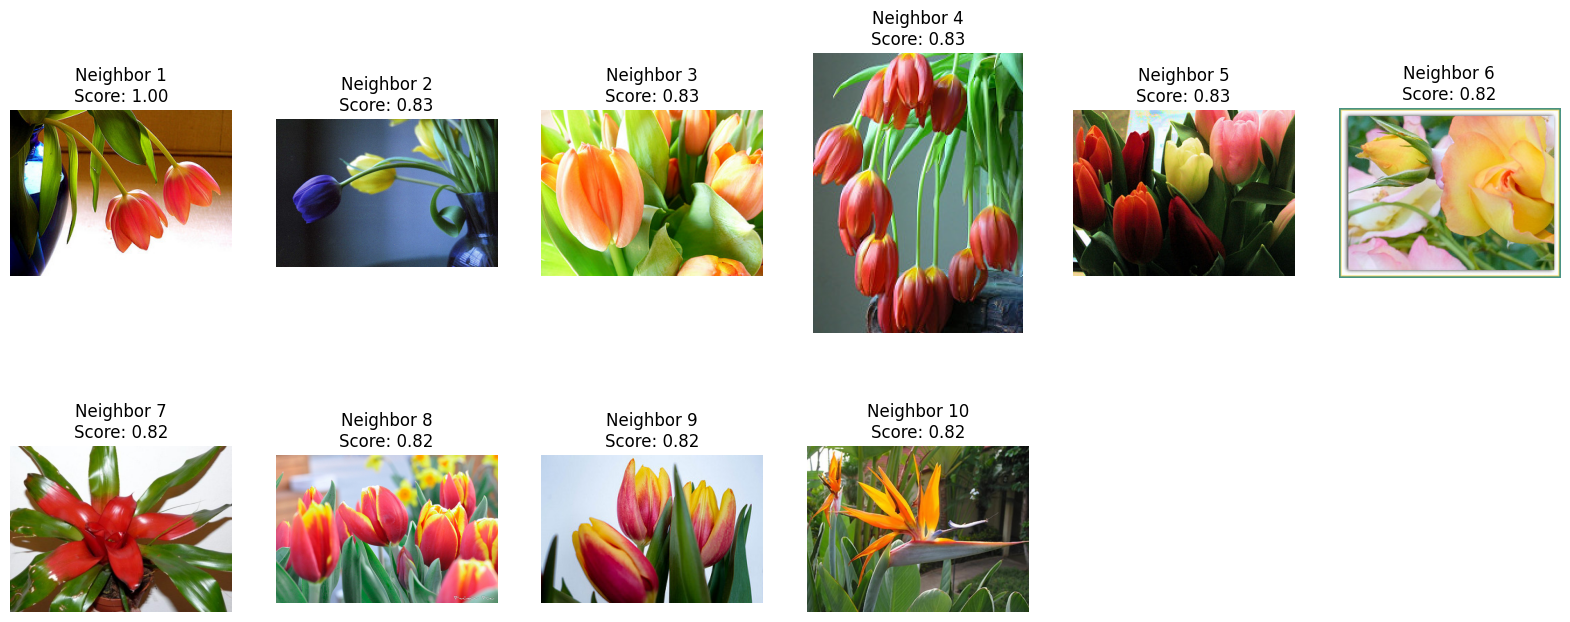

In [24]:
#Querying 10 nearest neighbors along with the actual images. 
query_image_path = '/home/slakkaraju/flowers/flowers/116343334_9cb4acdc57_n.jpg'
query_embedding = get_embedding(query_image_path).tolist()

# Retrieve top 10 neighbors to be safe
search_result = client.search(
    collection_name=collection_name,
    query_vector=query_embedding,
    limit=10  # get more results to compensate for filtering
)

# Filter out the query image itself
filtered_results = [point for point in search_result if point.payload['filepath'] != query_image_path]

# Select top 5 excluding the query image
top_neighbors = filtered_results[:10]

print("Nearest Neighbors excluding query image:")
for point in top_neighbors:
    print(f"ID: {point.id}, Score: {point.score:.4f}, Filepath: {point.payload['filepath']}, Cluster: {point.payload['cluster']}")

plt.figure(figsize=(20, 8))

# Show query image first
query_img = Image.open(query_image_path)
plt.subplot(2, 6, 1)
plt.imshow(query_img)
plt.title("Query Image")
plt.axis('off')

# Show nearest neighbor images
for i, point in enumerate(search_result):
    neighbor_img_path = point.payload['filepath']
    neighbor_img = Image.open(neighbor_img_path)
    plt.subplot(2, 6, i + 1)
    plt.imshow(neighbor_img)
    plt.title(f"Neighbor {i + 1}\nScore: {point.score:.2f}")
    plt.axis('off')

plt.show()

/tmp/ipykernel_37524/3808078315.py:5: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


Nearest Neighbors excluding query image:
ID: 4944, Score: 0.8556, Filepath: /home/slakkaraju/flowers/flowers/2535495431_e6f950443c.jpg, Cluster: 4
ID: 2055, Score: 0.8403, Filepath: /home/slakkaraju/flowers/flowers/9216323421_f737c1d50e.jpg, Cluster: 4
ID: 4913, Score: 0.8327, Filepath: /home/slakkaraju/flowers/flowers/4860145119_b1c3cbaa4e_n.jpg, Cluster: 4
ID: 3317, Score: 0.8306, Filepath: /home/slakkaraju/flowers/flowers/14414100710_753a36fce9.jpg, Cluster: 4
ID: 7426, Score: 0.8259, Filepath: /home/slakkaraju/flowers/flowers/image_01231.jpg, Cluster: 4
ID: 807, Score: 0.8256, Filepath: /home/slakkaraju/flowers/flowers/image_01224.jpg, Cluster: 4
ID: 11306, Score: 0.8187, Filepath: /home/slakkaraju/flowers/flowers/1949195327_75f76c12b1.jpg, Cluster: 4
ID: 11673, Score: 0.8184, Filepath: /home/slakkaraju/flowers/flowers/image_01204.jpg, Cluster: 4
ID: 586, Score: 0.8171, Filepath: /home/slakkaraju/flowers/flowers/image_01201.jpg, Cluster: 4


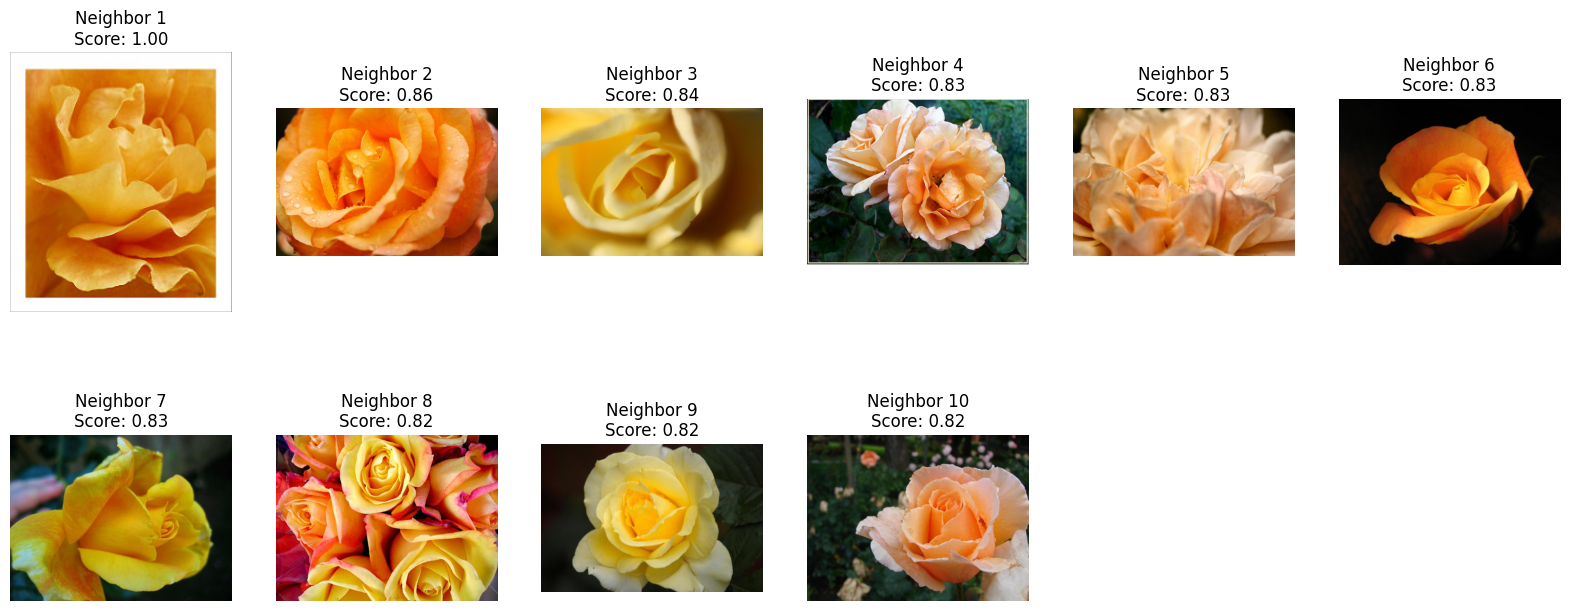

In [25]:
query_image_path = '/home/slakkaraju/flowers/flowers/534228982_4afbcece9b_m.jpg'
query_embedding = get_embedding(query_image_path).tolist()

# Retrieve top 10 neighbors to be safe
search_result = client.search(
    collection_name=collection_name,
    query_vector=query_embedding,
    limit=10  # get more results to compensate for filtering
)

# Filter out the query image itself
filtered_results = [point for point in search_result if point.payload['filepath'] != query_image_path]

# Select top 5 excluding the query image
top_neighbors = filtered_results[:10]

print("Nearest Neighbors excluding query image:")
for point in top_neighbors:
    print(f"ID: {point.id}, Score: {point.score:.4f}, Filepath: {point.payload['filepath']}, Cluster: {point.payload['cluster']}")

plt.figure(figsize=(20, 8))

# Show query image first
query_img = Image.open(query_image_path)
plt.subplot(2, 6, 1)
plt.imshow(query_img)
plt.title("Query Image")
plt.axis('off')

# Show nearest neighbor images
for i, point in enumerate(search_result):
    neighbor_img_path = point.payload['filepath']
    neighbor_img = Image.open(neighbor_img_path)
    plt.subplot(2, 6, i + 1)
    plt.imshow(neighbor_img)
    plt.title(f"Neighbor {i + 1}\nScore: {point.score:.2f}")
    plt.axis('off')

plt.show()